*Pendant les 3 premières séances de TP, nous allons mettre en pratique certaines des méthodes présentées en cours pour détecter des objets dans une image.*

# Localisation et classification d'objet




## Introduction

Dans cette partie, nous allons nous concentrer sur le problème de la localisation d'un seul objet par classe. La base de données a été épurée pour se concentrer uniquement sur ce cas.

En localisation et détection, on cherche à déterminer la position d'un objet, ainsi que sa classe, sous la forme d'une boîte englobante de largeur $b_w$ et hauteur $b_h$, et dont le centre a pour coordonnées le point $(b_x, b_y)$.

<center> <img src="https://drive.google.com/uc?id=1_jHHv6ZDe-3Xz25jIZ6o177laBEfmMRR" style="width:500;height:300px;"></center>
<caption><center> Figure 1: Modèle de boîte englobante utilisé pour la localisation </center></caption>

Le problème de localisation considère qu'un seul objet est présent sur l'image, alors que le problème de détection cherche à déterminer l'ensemble des objets présents sur l'image.



Pour commencer, récupérez les images de la base de données :


In [3]:
!git clone https://github.com/axelcarlier/mangeoires_loc.git

fatal: destination path 'mangeoires_loc' already exists and is not an empty directory.


La base de données consiste en des photographies prises par une caméra reliée à une Raspberry Pi, cachée dans une mangeoire. Plusieurs mangeoires sont disséminées dans la nature en Occitanie, et l'objectif de [ce projet](https://econect.cnrs.fr/) est la reconnaissance des espèces et le comptage des individus qui viennent se poser devant le caméra, afin de suivre l'évolution des populations d'oiseaux et ainsi monitorer la biodiversité.

La base de données qui vous est fournie regroupe 11 espèces d'animaux, majoritairement des oiseaux, désignés par un code :

1. Mésange charbonnière (**MESCHA**)
2. Verdier d'Europe (**VEREUR**)
3. Écureuil roux (**ECUROU**)
4. Pie bavarde (**PIEBAV**)
5. Sittelle torchepot (**SITTOR**)
6. Pinson des arbres (**PINARB**)
7. Mésange noire (**MESNOI**)
8. Mésange nonnette (**MESNON**)
9. Mésange bleue (**MESBLE**)
10. Rouge-gorge (**ROUGOR**)
11. Accenteur mouchet (**ACCMOU**)



<center> <img src="https://drive.google.com/uc?id=1Eit86N4D0Ea7ai1rBa0o-GmTwckhP9i0" width=200>
<img src="https://drive.google.com/uc?id=1lC7WL93UqDT_KV2m21yx99N5dkf98nCY" width=200>
<img src="https://drive.google.com/uc?id=10tzJORcSrSckDWmBDBtc8FUirxdbRxri" width=200>
<img src="https://drive.google.com/uc?id=1IHZp_B6bc8bADtAReRHhcyOjDQZAXDBQ" width=200></center>
<caption><center> Figure 2: Exemples d'images de la base de données </center></caption>

In [4]:
import PIL
from PIL import Image
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam


## Préparation des données

Le code ci-dessous permet de charger les données et les formater pour la classification. Prenez le temps de regarder un peu le format des labels $y$.
Notez que les images sont rendues carrées lors du chargement.

In [5]:
# Lecture du CSV contenant les informations relatives à la base de données
dataset = []
with open('mangeoires_loc/bd_mangeoires_equilibre.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
	for row in filereader:
		data = row[0].split(',')
		if data[0] != 'Data':
			box = [float(data[5]), float(data[6]), float(data[7]), float(data[8])]
			new_entry = {'type': data[0], 'specie': data[1], 'path': data[2], 'shape': [float(data[3]), float(data[4])], 'box': box}
			dataset.append(new_entry)

# Nombre de classes de la base de données et intitulé des classes
class_labels = list(dict.fromkeys([item['specie'] for item in dataset]))
num_classes = len(class_labels)

# Extraction des données d'apprentissage et de test
dataset_train = [item for item in dataset if item['type']=='TRAIN']
dataset_test = [item for item in dataset if item['type']=='TEST']

print(class_labels)

['MESCHA', 'VEREUR', 'ECUROU', 'PIEBAV', 'SITTOR', 'PINARB', 'MESNOI', 'MESNON', 'MESBLE', 'ROUGOR', 'ACCMOU']


In [6]:
def build_localization_tensors(image_size, dataset, num_classes):
  # Préparation des structures de données pour x et y
  x = np.zeros((len(dataset), image_size, image_size, 3))
  y = np.empty((len(dataset), num_classes + 5)) # 1 + 4 + num_classes : présence / boîte englobante / classes

  # Compteur de parcours du dataset
  i = 0

  for item in dataset:
    # Lecture de l'image
    img = Image.open('mangeoires_loc/' + item['path'])
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
    # Remplissage de la variable x
    x[i] = np.asarray(img)

    y[i, 0] = 1 # Un objet est toujours présent !

    # Coordonnées de boîte englobante
    img_shape = item['shape']
    box = item['box']
    bx = (box[0] + (box[2] - box[0])/2)/img_shape[0]
    by = (box[1] + (box[3] - box[1])/2)/img_shape[1]
    bw = (box[2] - box[0])/img_shape[0]
    bh = (box[3] - box[1])/img_shape[1]
    y[i, 1] = bx
    y[i, 2] = by
    y[i, 3] = bw
    y[i, 4] = bh

    # Probabilités de classe, sous la forme d'une one-hot vector
    label = class_labels.index(item['specie'])
    classes_probabilities = keras.utils.to_categorical(label, num_classes=num_classes)
    y[i, 5:] = classes_probabilities

    i = i+1

  return x, y


Séparation des données d'entraînement pour extraire un ensemble de validation, et pré-traitement des données.

In [7]:
from sklearn.model_selection import train_test_split


# Pour la suite du TP on considèrera des images de taille 64x64x3
# Augmenter cette valeur donnerait de meilleurs résultats mais nécessiterait des calculs plus long.
IMAGE_SIZE = 64

# Lecture des données d'entraînement et de test
x, y = build_localization_tensors(IMAGE_SIZE, dataset_train, num_classes)
x_test, y_test = build_localization_tensors(IMAGE_SIZE, dataset_test, num_classes)

#Extraction d'un ensemble de validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)

# Pour améliorer l'entraînement, on peut centrer-réduire les coordonnées des bounding boxes...
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[...,1:5] = (y_train[...,1:5] - y_mean[1:5])/y_std[1:5]
y_val[...,1:5] = (y_val[...,1:5] - y_mean[1:5])/y_std[1:5]
y_test[...,1:5] = (y_test[...,1:5] - y_mean[1:5])/y_std[1:5]

# ... et normaliser les valeurs de couleur
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

## Fonctions utiles

Une fonction de calcul de l'intersection sur union, qui nous sera utile pour les métriques d'évaluation de nos méthodes :

$$ IoU (R_1, R_2) = \frac{\mathcal{A} (R_1 \cap R_2)}{\mathcal{A} (R_1 \cup R_2)} = \frac{\mathcal{A} (R_1 \cap R_2)}{\mathcal{A} (R_1) + \mathcal{A} (R_2) -  \mathcal{A} (R_1 \cap R_2)} $$

<center>
<img src="https://drive.google.com/uc?id=1BQx2kDOCltZ_5gcnKVWTVUVNmGk-7qBC" width=500>
</center>


In [8]:
### A COMPLETER
def intersection_sur_union(box1, box2):
  """
  Calcul de l'intersection sur union entre deux rectangles box1 et box2

  Arguments:
  box1, box2 -- les coordonnées des deux rectangles, chacun sous la forme [cx, cy, w, h]
                où (cx, cy) désigne les coordonnées du centre du rectangle,
                w sa largeur et h sa hauteur

  Retourne :
  iou -- la valeur d'intersection sur union entre les deux rectangles
  """

  x1 = box1[0] - box1[2] / 2
  y1 = box1[1] - box1[3] / 2
  x2 = box1[0] + box1[2] / 2
  y2 = box1[1] + box1[3] / 2
  x3 = box2[0] - box2[2] / 2
  y3 = box2[1] - box2[3] / 2
  x4 = box2[0] + box2[2] / 2
  y4 = box2[1] + box2[3] / 2

  x5 = max(x1,x3)
  y5 = max(y1,y3)
  x6 = min(x2,x4)
  y6 = min(y2,y4)

  aire1 = (x2 - x1) * (y2 - y1)
  aire2 = (x4 - x3) * (y4 - y3)
  intersection = (x6 - x5) * (y6 - y5)
  union = aire1 + aire2 - intersection

  return intersection / union


Exécutez le bloc suivant pour vérifier votre implémentation :

In [9]:
print(intersection_sur_union([2.5, 2, 1, 4], [2, 3, 4, 2]))  # Résultat attendu : 0.2
print(intersection_sur_union([2.5, 2, 1, 4], [5, 3, 4, 2]))  # Résultat attendu : 0.0

0.2
0.0


On va maintenant calculer les différentes métriques :

$$ P = \frac{TP}{TP + FP} $$

$$ R = \frac{TP}{TP + FN} $$

$$ F1 = \frac{2 * P * R}{P + R} $$

où $TP$ désigne le nombre de vrais positifs, $FP$ le nombre de faux positifs, $FN$ le nombre de faux négatifs, $P$ la précision, $R$ le rappel et $F1$ le F1-score.

On considère souvent qu'une détection est correcte si la classification est valide et que l'intersection sur union entre vérité terrain et prédiction est supérieure à 0.5 (on utilisera un seuil modifiable *iou_thres*).

In [10]:
# On considère souvent qu'une détection est correcte si la classification est valide et que
# l'intersection sur union entre vérité terrain et prédiction est supérieure à 0.5
def global_accuracy(y_true, y_pred, iou_thres=0.5):
  """
  Calcul, pour chaque classe de la précision, du rappel et du F1-score ainsi
  que du pourcentage global de bonnes détections.

  Arguments:
  y_true -- les labels de la vérité terrain, de dimension (M, 1+4+N) où M désigne
          le nombre d'éléments du dataset et N le nombre de classes (11 dans notre cas)
  y_pred -- les labels prédits par un modèle, de dimension (M, 1+4+N)
  iou_thres -- seuil d'intersection sur union entre une boîte "vérité-terrain" et
              une boite prédite au-dessus duquel on considère que la prédiction est correcte

  Retourne :
  class_res -- liste de longueur N contenant des dictionnaires sous la forme
            {"Précision": p, "Rappel": r, "F-score": f} résumant les métriques
            précision, rappel et F1-score pour chacune des classes.
  accuracy -- pourcentage global de bonnes détections
  """
  # Initialisation des métriques : nombre de vrais positifs (TP), faux positifs (FP)
  # et faux négatifs (FN) pour chaque classe
  class_metrics = []
  for i in range(num_classes):
    class_metrics.append({'TP': 0, 'FP': 0, 'FN': 0})

  # Nombres de détections correctes et de détections incorrectes
  total_correct_detections = 0
  total_incorrect_detections = 0
  for i in range(y_true.shape[0]):
    # Labels vérité-terrain et prédits
    groundtruth_label = np.argmax(y_true[i,5:])
    predicted_label = np.argmax(y_pred[i,5:])

    # Coordonnées de boîtes englobantes réelles et prédites
    bx_true = (y_true[i,1]*y_std[1] + y_mean[1])
    by_true = (y_true[i,2]*y_std[2] + y_mean[2])
    bw_true = (y_true[i,3]*y_std[3] + y_mean[3])
    bh_true = (y_true[i,4]*y_std[4] + y_mean[4])
    bx_pred = (y_pred[i,1]*y_std[1] + y_mean[1])
    by_pred = (y_pred[i,2]*y_std[2] + y_mean[2])
    bw_pred = (y_pred[i,3]*y_std[3] + y_mean[3])
    bh_pred = (y_pred[i,4]*y_std[4] + y_mean[4])

    # Calcul de l'intersection sur union
    iou = intersection_sur_union([bx_true, by_true, bw_true, bh_true], [bx_pred, by_pred, bw_pred, bh_pred])

    ### A COMPLETER
    # Si la détection est correcte :
    if groundtruth_label == predicted_label and iou > iou_thres:
      # Mettre à jour le nombre de Vrais Positifs pour la classe vérité terrain :
      class_metrics[groundtruth_label]['TP'] += 1
      total_correct_detections += 1

    else:
      # Mettre à jour le nombre de Faux Positifs et/ou Faux Négatifs pour les
      # classes concernées
      class_metrics[predicted_label]['FP'] += 1
      class_metrics[groundtruth_label]['FN'] += 1
      total_incorrect_detections += 1

  class_res = []
  for i in range(num_classes):
    # Pour chaque classe, on veut calculer Précision, Rappel et F1-Score à partir
    # des TP, FP et FN calculés sur le bloc précédent
    if class_metrics[i]['TP'] == 0:
      P = 0
      R = 0
    else:
      P = class_metrics[i]['TP'] / (class_metrics[i]['TP'] + class_metrics[i]['FP'])
      R = class_metrics[i]['TP'] / (class_metrics[i]['TP'] + class_metrics[i]['FN'])

    if (P == 0) & (R == 0):
      F_score = 0
    else:
      F_score = 2 * P * R / (P + R)
    class_res.append({'Precision': P, 'Rappel': R, 'F-score': F_score})

  accuracy = 100 * total_correct_detections / (total_correct_detections + total_incorrect_detections)
  ### FIN
  return class_res, accuracy

In [11]:
num_class_test = 3
class_labels_test = ['Classe 1', 'Classe 2', 'Classe 3']
y_true_test = np.ones((num_class_test,8))
y_true_test[0,:2] = [0.5, 0.5]
y_true_test[0, 5:] = [1, 0, 0]
y_true_test[1,:2] = [0.5, 0.5]
y_true_test[1, 5:] = [0, 1, 0]
y_true_test[2,:2] = [0.5, 0.5]
y_true_test[2, 5:] = [0, 0, 1]
y_pred_test = np.ones((num_class_test,8))
y_pred_test[0,:2] = [0.6, 0.6]
y_pred_test[0, 5:] = [1, 0, 0]
y_pred_test[1,:2] = [2.5, 2.5]
y_pred_test[1, 5:] = [0, 0, 1]
y_pred_test[2,:2] = [0.6, 0.6]
y_pred_test[2, 5:] = [0, 0, 1]

class_res_test, acc_test = global_accuracy(y_true_test, y_pred_test)

print(f"La précision globale est de {acc_test:.1f}%")

print()
print("--------------------------------------------")
print("|  Classe  | Précision | Rappel | F1-score |")
print("--------------------------------------------")
for i in range(num_class_test):
  print(f"| {class_labels_test[i]:9s}|   {class_res_test[i]['Precision']:.2f}    |  {class_res_test[i]['Rappel']:.2f}  |   {class_res_test[i]['F-score']:.2f}   |")
  print("--------------------------------------------")

La précision globale est de 66.7%

--------------------------------------------
|  Classe  | Précision | Rappel | F1-score |
--------------------------------------------
| Classe 1 |   1.00    |  1.00  |   1.00   |
--------------------------------------------
| Classe 2 |   0.00    |  0.00  |   0.00   |
--------------------------------------------
| Classe 3 |   0.50    |  1.00  |   0.67   |
--------------------------------------------


**Affichage attendu :**
```
La précision globale est de 66.7%

--------------------------------------------
|  Classe  | Précision | Rappel | F1-score |
--------------------------------------------
| Classe 1 |   1.00    |  1.00  |   1.00   |
--------------------------------------------
| Classe 2 |   0.00    |  0.00  |   0.00   |
--------------------------------------------
| Classe 3 |   0.50    |  1.00  |   0.67   |
--------------------------------------------
```

La fonction ci-dessous permet de calculer l'intersection sur union  sur des tenseurs (et non des tableaux numpy), elle sera donc utilisable comme métrique pendant l'entraînement.

In [12]:
def compute_iou(y_true, y_pred):
  ### "Dénormalisation" des coordonnées des boîtes englobantes
  pred_box_xy = y_pred[..., 0:2]* y_std[0:2] + y_mean[0:2]
  true_box_xy = y_true[..., 0:2]* y_std[0:2] + y_mean[0:2]

  ### "Dénormalisation" des largeur et hauteur des boîtes englobantes
  pred_box_wh = y_pred[..., 2:4] * y_std[2:4] + y_mean[2:4]
  true_box_wh = y_true[..., 2:4] * y_std[2:4] + y_mean[2:4]

  # Calcul des coordonnées minimales et maximales des boiptes englobantes réelles
  true_wh_half = true_box_wh / 2.
  true_mins    = true_box_xy - true_wh_half
  true_maxes   = true_box_xy + true_wh_half

  # Calcul des coordonnées minimales et maximales des boiptes englobantes prédites
  pred_wh_half = pred_box_wh / 2.
  pred_mins    = pred_box_xy - pred_wh_half
  pred_maxes   = pred_box_xy + pred_wh_half

  # Détermination de l'intersection des boîtes englobantes
  intersect_mins  = tf.maximum(pred_mins,  true_mins)
  intersect_maxes = tf.minimum(pred_maxes, true_maxes)
  intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

  # Aire des boîtes englobantes prédites et réelles
  true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
  pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

  # Aire de l'union des boîtes prédites et réelles
  union_areas = pred_areas + true_areas - intersect_areas

  iou_scores  = tf.truediv(intersect_areas, union_areas)
  return iou_scores

def iou():
  def iou_metrics(y_true, y_pred):
    return compute_iou(y_true, y_pred)
  iou_metrics.__name__= "iou"
  return iou_metrics

Visualisation des données et labels

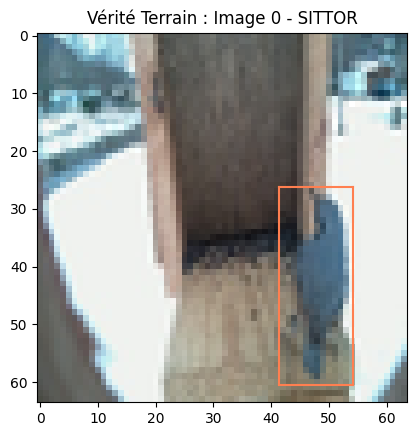

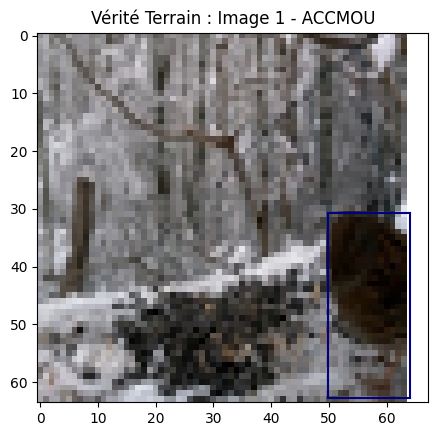

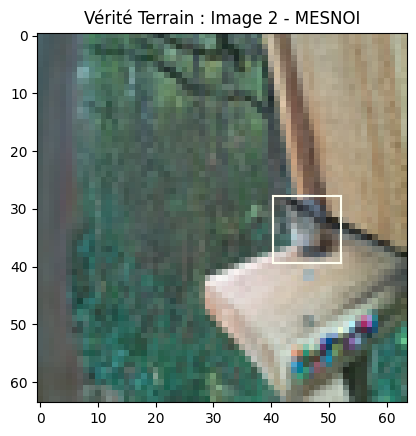

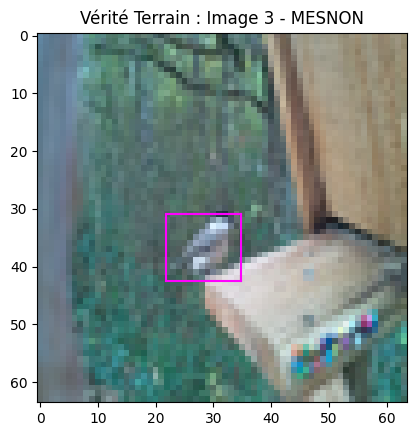

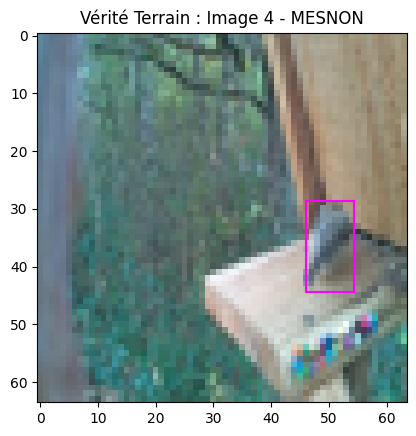

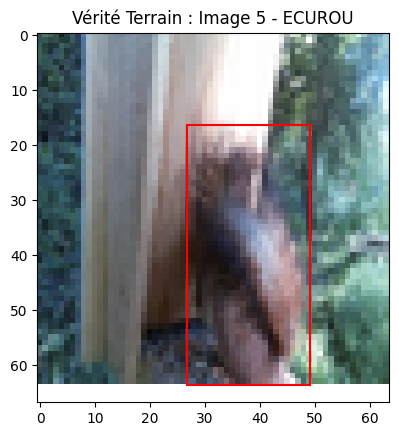

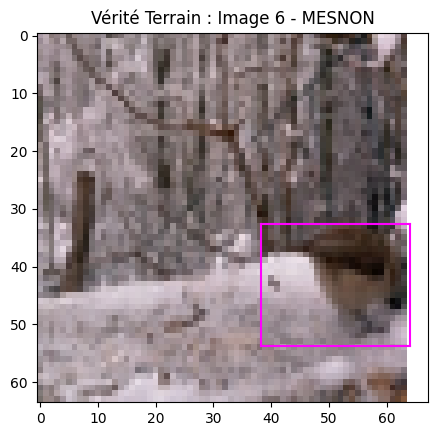

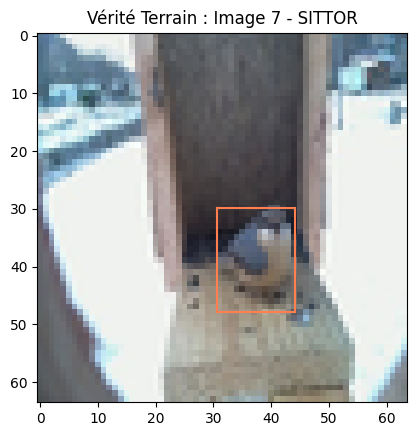

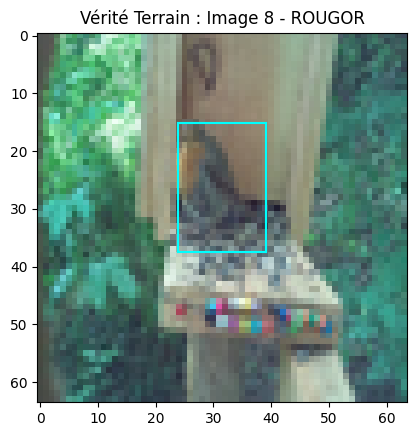

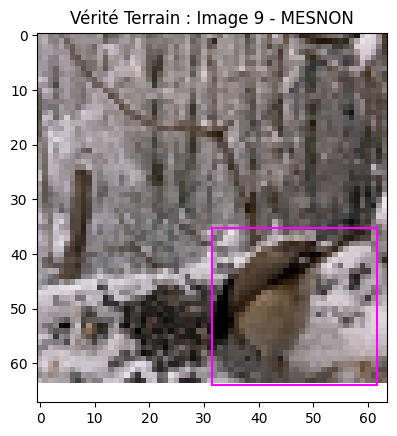

In [13]:
# Si seuls x et y sont indiqués, on tire au hasard un numéro d'image et on affiche le label y associé  à l'image
# Si un 2e y, nommé y_pred, est indiqué, alors les deux labels sont affichés côte à côte, afin de pouvoir les comparer
# Enfin on peut également indiquer l'id de l'image que l'on souhaite visualiser.
def print_data_localisation(x, y, y_pred=[], id=None, image_size=64):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id

  img = x[num_img]
  lab = y[num_img]

  colors = ["blue", "yellow", "red", "orange", "coral", "gold", "ivory", "fuchsia", "purple", "cyan", "navy"] # Différentes couleurs pour les différentes classes
  classes = ['MESCHA', 'VEREUR', 'ECUROU', 'PIEBAV', 'SITTOR', 'PINARB', 'MESNOI', 'MESNON', 'MESBLE', 'ROUGOR', 'ACCMOU']

  if np.any(y_pred):
    plt.subplot(1, 2, 1)

  # Affichage de l'image
  plt.imshow(img)
  # Détermination de la classe
  class_id = np.argmax(lab[5:])

  # Détermination des coordonnées de la boîte englobante dans le repère image
  ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
  ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
  width = (lab[3]*y_std[3] + y_mean[3]) * image_size
  height = (lab[4]*y_std[4] + y_mean[4]) * image_size
  #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
  # Détermination des extrema de la boîte englobante
  p_x = [ax-width/2, ax+width/2]
  p_y = [ay-height/2, ay+height/2]
  # Affichage de la boîte englobante, dans la bonne couleur
  plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
  plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
  plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
  plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
  plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))

  if np.any(y_pred):
    plt.subplot(1, 2, 2)
    # Affichage de l'image
    plt.imshow(img)
    lab = y_pred[num_img]
    # Détermination de la classe
    class_id = np.argmax(lab[5:])

    # Détermination des coordonnées de la boîte englobante dans le repère image
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [ax-width/2, ax+width/2]
    p_y = [ay-height/2, ay+height/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Prédiction : Image {} - {}".format(num_img, classes[class_id]))

  plt.show()

for i in range(10):#x.shape[0]):
    print_data_localisation(x_train, y_train, image_size=IMAGE_SIZE, id=i)


Fonction d'affichage des courbes d'apprentissage et de validation

In [14]:
def plot_training_analysis(history, metric='loss'):

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.show()

## Travail à faire



<center> <img src="https://drive.google.com/uc?id=1YzCZe4pgnjJDVGklAaCHZ7HhlPJsadg9" width=500></center>
<caption><center> Figure 3: Illustration de l'architecture du réseau à construire.  </center></caption>

Complétez les codes qui vous sont fournis pour obtenir un algorithme de localisation.
Vous pouvez utiliser n'importe quelle base convolutive de votre choix (vous pouvez vous inspirer du TP sur les CNN que nous avons fait l'an passé), en revanche vous devrez porter une attention particulière à la couche de sortie.

Vous allez en fait produire 3 sorties différentes : une caractérisant la présence d'un objet, une autre fournissant les coordonnées de la boîte englobante, et enfin une dernière effectuant la classification.

In [15]:
def create_model_localisation(input_shape=(64, 64, 3)):

  input_layer = Input(shape=input_shape)

  vgg = conv_base(input_layer)

  # conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  # ### A COMPLETER
  # conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  # pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  # conv3 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  # pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  # conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  # pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  # # Cette couche vectorise le tenseur de sortie de votre base convolutive, et
  # # constituera l'entrée des 3 couches de sortie ci-dessous
  prev_layer = Flatten()(vgg)

  #### Couches de sortie A COMPLETER
  output_p = Dense(1, activation='sigmoid', name='p')(prev_layer)   # Sortie caractérisant la présence d'un objet
  output_coord = Dense(4, activation='linear', name='coord')(prev_layer) # Sortie caractérisant les coordonnées de boîte englobante
  output_class = Dense(num_classes, activation='softmax', name='classes')(prev_layer) # Sortie caractérisant les probabilités de classe

  output= [output_p, output_coord, output_class]
  model = Model(input_layer, output)

  return model

<center> <img src="https://drive.google.com/uc?id=1bnh8zU7Os-w-5TT8hV4xDoThKQc-Ywc2" width=500></center>
<caption><center> Figure 4: Illustration des fonctions de coût à utiliser pour l'entraînement. </center></caption>

Pour entraîner votre réseau, vous allez donc devoir associer une fonction de coût à chacune des sorties du réseau. La fonction de coût totale sera la somme des trois fonctions de coût précédemment définies, pondérées par des poids définis dans la variable *loss_weights*.

**Prenez le temps de tester différentes valeurs de *loss_weights* en fonction de l'évolution des métriques que vous observerez pendant l'entraînement.**

Vous évaluerez vos résultats de manière qualitative (en affichant les boîtes englobantes prédites et réelles) mais aussi quantitatives grâce aux fonctions définies dans la section précédente. **N'hésitez pas à modifier un peu le paramètre iou_threshold positionné par défaut à 0.5** (une valeur de 0.4 vous permettra d'obtenir de meilleurs résultats !)

In [ ]:
batch_size=16
model = create_model_localisation()
opt = Adam(learning_rate=3e-4)

# Ici mettre, dans l'ordre, les fonctions de coût associées à chacune des sorties
loss=['binary_crossentropy', 'mse', 'categorical_crossentropy']
# On va associer une métrique à chaque sortie : l'accuracy pour les deux classifications,
# et l'IoU définie plus tôt pour la qualité des boîtes englobantes.
metrics=[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1, 1, 1]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )
history = model.fit(train_gen,
              epochs=50,
              batch_size=batch_size,
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:]]))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - classes_accuracy: 0.1528 - classes_loss: 2.3446 - coord_iou: 0.3483 - coord_loss: 1.0406 - loss: 3.4947 - p_accuracy: 0.9549 - p_loss: 0.1094 - val_classes_accuracy: 0.4619 - val_classes_loss: 1.5477 - val_coord_iou: 0.4701 - val_coord_loss: 0.6562 - val_loss: 2.2336 - val_p_accuracy: 1.0000 - val_p_loss: 0.0026
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - classes_accuracy: 0.4357 - classes_loss: 1.5129 - coord_iou: 0.4448 - coord_loss: 0.6606 - loss: 2.1767 - p_accuracy: 1.0000 - p_loss: 0.0031 - val_classes_accuracy: 0.5095 - val_classes_loss: 1.4049 - val_coord_iou: 0.4212 - val_coord_loss: 0.5867 - val_loss: 1.9657 - val_p_accuracy: 1.0000 - val_p_loss: 4.2376e-04
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - classes_accuracy: 0.5159 - classes_loss: 1.2652 - coord_iou: 0.4802 - coord_loss: 0.5739 - loss: 1.8406 - p_accuracy: 1.0000 - p_loss: 0.0013 - val_classes_accuracy: 0.5857 - val_classes_loss: 1.0155 - val_coord_

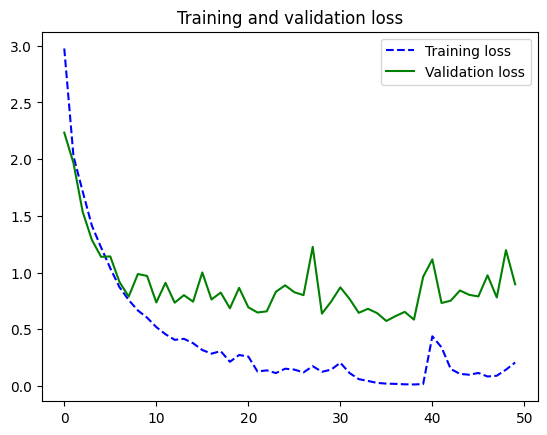

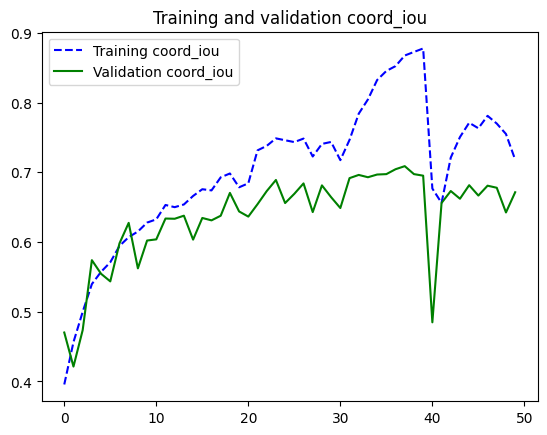

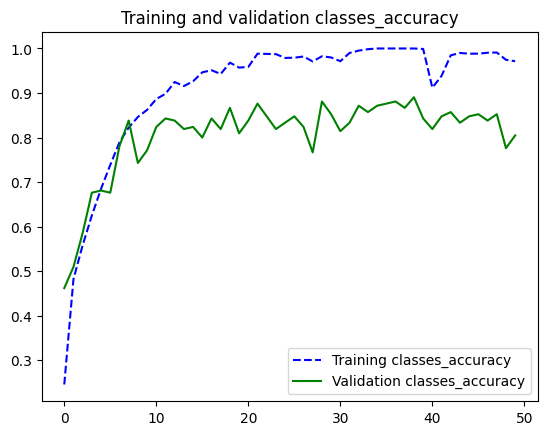

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step


<ipython-input-24-15ce3399c08c>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i, 0] = y_pred_presence[i]


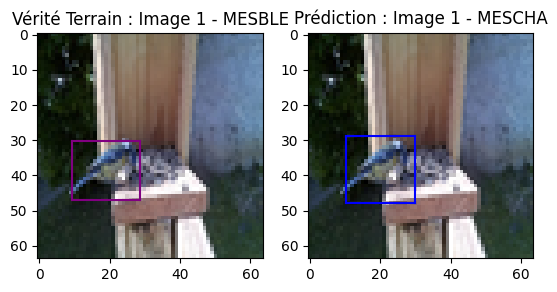

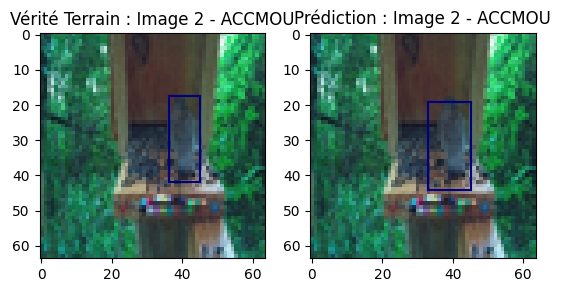

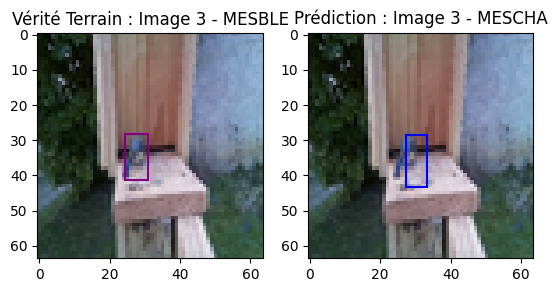

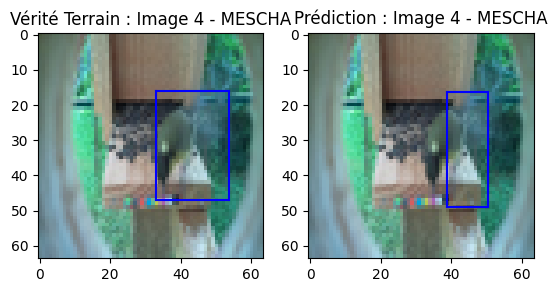

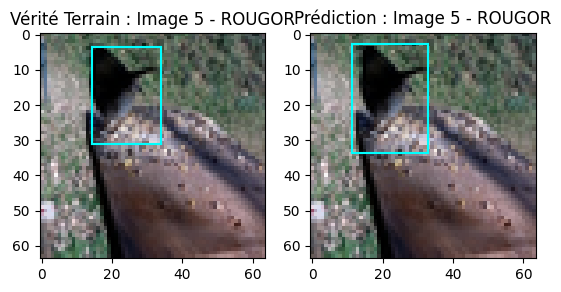

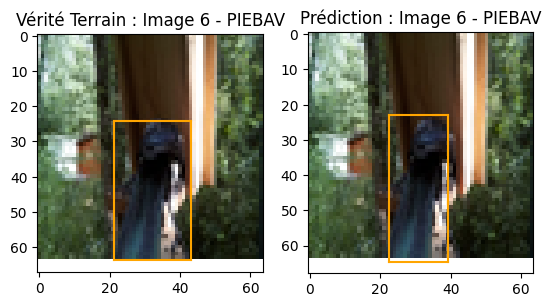

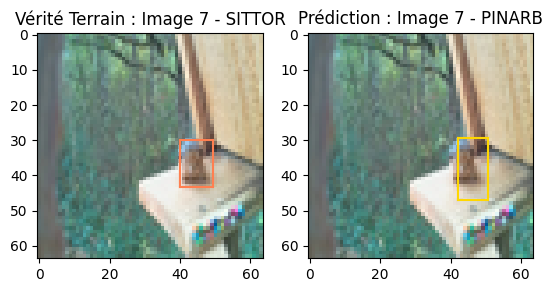

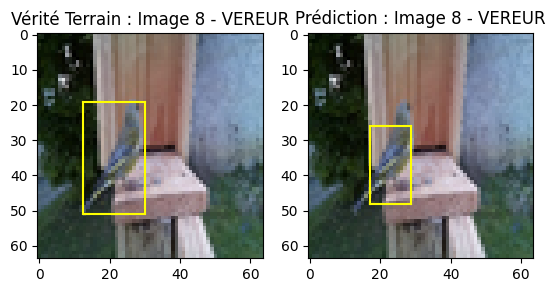

In [ ]:
# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de la précision des classes prédites
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_iou')
plot_training_analysis(history, metric='classes_accuracy')

# Prédiction des données de test
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_test)
y_pred = np.zeros(y_test.shape)
for i in range(y_pred.shape[0]):
  y_pred[i, 0] = y_pred_presence[i]
  y_pred[i, 1:5] = y_pred_coords[i]
  y_pred[i, 5:] = y_pred_classes[i]

# Affichage des résultats sur plusieurs images
print_data_localisation(x_test, y_test, y_pred = y_pred, id=1, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=4, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=5, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=6, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=8, image_size=IMAGE_SIZE)

In [ ]:
class_res, accuracy = global_accuracy(y_test, y_pred)

print(f"La précision globale est de {accuracy:.1f}%")

print()
print("------------------------------------------")
print("| Classe | Précision | Rappel | F1-score |")
print("------------------------------------------")
for i in range(num_classes):
  print(f"| {class_labels[i]:7s}|   {class_res[i]['Precision']:.2f}    |  {class_res[i]['Rappel']:.2f}  |   {class_res[i]['F-score']:.2f}   |")
  print("------------------------------------------")


La précision globale est de 65.7%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| MESCHA |   0.48    |  0.55  |   0.51   |
------------------------------------------
| VEREUR |   0.76    |  0.73  |   0.74   |
------------------------------------------
| ECUROU |   0.95    |  0.91  |   0.93   |
------------------------------------------
| PIEBAV |   0.95    |  0.91  |   0.93   |
------------------------------------------
| SITTOR |   0.77    |  0.45  |   0.57   |
------------------------------------------
| PINARB |   0.74    |  0.77  |   0.76   |
------------------------------------------
| MESNOI |   0.29    |  0.43  |   0.34   |
------------------------------------------
| MESNON |   0.31    |  0.36  |   0.33   |
------------------------------------------
| MESBLE |   0.57    |  0.55  |   0.56   |
------------------------------------------
| ROUGOR |   0.79    |  0.71  |   0.75   |
-------------------

En pratique, il est délicat de trouver une bonne combinaison des fonctions de perte tel que vous l'avez fait sur les cellules précédentes. L'entropie croisée et l'erreur quadratique moyenne donnent des valeurs trop différentes pour être combinables efficacement.

Une variante, peut-être plus simple à faire fonctionner, est d'utiliser uniquement l'erreur quadratique moyenne comme perte pour toutes les sorties. C'est cette variante qui est implémentée dans l'algorithme YOLO, dont nous implémenterons une version simplifiée dans la suite du TP.
Testez cette solution ci-dessous. Comme sur l'exercice précédent, n'hésitez pas à faire varier le poids des différents éléments de la fonction de coût.

In [16]:
batch_size=16
model = create_model_localisation()
opt = Adam(learning_rate=3e-4)

loss = ['mse', 'mse', 'mse']
metrics =[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1,1,1]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )
history = model.fit(train_gen,
              epochs=50,
              batch_size=batch_size,
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:]]))


NameError: name 'conv_base' is not defined

In [ ]:
# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de la précision des classes prédites
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_iou')
plot_training_analysis(history, metric='classes_accuracy')

# Prédiction des données de test
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_test)
y_pred = np.zeros(y_test.shape)
for i in range(y_pred.shape[0]):
  y_pred[i, 0] = y_pred_presence[i]
  y_pred[i, 1:5] = y_pred_coords[i]
  y_pred[i, 5:] = y_pred_classes[i]

# Affichage des résultats sur plusieurs images
print_data_localisation(x_test, y_test, y_pred = y_pred, id=1, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=4, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=5, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=6, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=8, image_size=IMAGE_SIZE)


class_res, accuracy = global_accuracy(y_test, y_pred, iou_thres=0.4)

print(f"La précision globale est de {accuracy:.1f}%")

print()
print("------------------------------------------")
print("| Classe | Précision | Rappel | F1-score |")
print("------------------------------------------")
for i in range(num_classes):
  print(f"| {class_labels[i]:7s}|   {class_res[i]['Precision']:.2f}    |  {class_res[i]['Rappel']:.2f}  |   {class_res[i]['F-score']:.2f}   |")
  print("------------------------------------------")


Compte-tenu de la taille réduite de la base de données, les résultats ne sont pas mal du tout ! On observe quelques confusions entre certaines classes mais les prédictions sont souvent intéressantes.

**Fin de la séance 1**

---




**Pour aller plus loin :**

Il devrait cependant subsister un fort surapprentissage à ce stade. Comme nous l'avons vu en première année, vous avez plusieurs possibilités qui s'offrent à vous pour le corriger :

*   Augmentation de la base de données. Vous pouvez pour cela vous appuyer sur le code fourni cu-dessous, avec une classe *Sequence* et l'utilisation de la librairie *Albumentation*.
*   Utilisation de *transfer learning* : partant d'un réseau entraîné sur ImageNet (qui contient de nombreuses classes d'animaux), vous bénéficieriez de filtres très généraux qui aiderait à limiter le surapprentissage.



## Quelques bouts de code pour vous aider à aller un peu plus loin

L'augmentation seule aide déjà un peu, mais le transfer learning accompagné d'augmentation de données donne les meilleurs résultats, avec presque 80% de bonnes détections !

### Augmentation de données

Le bloc de code suivant permet de définir des transformations colorimétriques à appliquer à notre base de données, de manière à augmenter artificiellement le nombre d'images de celles-ci :

In [17]:
from albumentations import (Compose, RandomBrightnessContrast, RandomGamma, ShiftScaleRotate, RandomSizedBBoxSafeCrop)
import albumentations as A

AUGMENTATIONS_TRAIN = Compose([
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


En première année, nous avons implémenté l'augmentation de données à l'aide d'un objet ImageDataGenerator. La limite de cette méthode est qu'elle ne peut s'appliquer que dans des cas où l'augmentation de données ne modifie pas le label associé à l'image. C'était le cas dans le TP de l'an passé sur les chiens et les chats : appliquer une rotation ou une translation à une image de chien (ou de chat) ne changeait rien au fait que l'image montrait un chien (ou un chat).

Ici, il peut arriver que certaines transformations altèrent le label : une rotation appliquée à un objet en changera nécessairement les coordonnées de boîte englobante.
Pour gérer cette difficulté, on va implémenter nous même le chargement des données, à l'aide d'un objet ```Sequence``` (défini ci-dessous).

La méthode ```__get_item()__``` récupère les données et labels du prochain batch à fournir au modèle pour la descente de gradient. On peut ainsi, à la volée, appliquer l'augmentation de données sur les images et impacter la modification sur les labels associés (fonction ```apply_augmentation```).

In [18]:
from tensorflow.keras.utils import Sequence

class MangeoireSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.classes = ['MESCHA', 'VEREUR', 'ECUROU', 'PIEBAV', 'SITTOR', 'PINARB', 'MESNOI', 'MESNON', 'MESBLE', 'ROUGOR', 'ACCMOU']
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0])
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    # Il y a des problèmes d'arrondi dans les conversions de boîtes englobantes
    # internes à la librairie Albumentations
    # Pour les contourner, si les boîtes sont trop proches des bords, on les érode un peu
    def erode_bounding_box(self, box):
        epsilon = 0.01

        xmin = max(box[0] - box[2]/2, epsilon)
        ymin = max(box[1] - box[3]/2, epsilon)
        xmax = min(box[0] + box[2]/2, 1-epsilon)
        ymax = min(box[1] + box[3]/2, 1-epsilon)

        cx = xmin + (xmax - xmin)/2
        cy = ymin + (ymax - ymin)/2
        width = xmax - xmin
        height = ymax - ymin

        return np.array([cx, cy, width, height])

    # Application de l'augmentation de données à chaque image du batch et aux
    # boîtes englobantes associées
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros((bx.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        batch_y = by

        # Pour chaque image du batch
        for i in range(len(bx)):
            bboxes = []
            box = by[i,1:5]
            # Dénormalisation des coordonnées de boites englobantes
            box[0] = (box[0]*y_std[1] + y_mean[1])
            box[1] = (box[1]*y_std[2] + y_mean[2])
            box[2] = (box[2]*y_std[3] + y_mean[3])
            box[3] = (box[3]*y_std[4] + y_mean[4])
            box = self.erode_bounding_box(box)
            bboxes.append(box)

            class_labels = []
            class_id = np.argmax(by[i, 5:])
            class_labels.append(self.classes[class_id])

            img = bx[i]

            # Application de l'augmentation à l'image et aux masques
            transformed = self.augment(image=img.astype('float32'), bboxes=bboxes, class_labels=class_labels)
            batch_x[i] = transformed['image']
            batch_y_transformed = transformed['bboxes']

            # Renormalisation des coordonnées de boîte englobante transformée
            batch_y[i, 1] = (batch_y_transformed[0][0] - y_mean[1])/y_std[1]
            batch_y[i, 2] = (batch_y_transformed[0][1] - y_mean[2])/y_std[2]
            batch_y[i, 3] = (batch_y_transformed[0][2] - y_mean[3])/y_std[3]
            batch_y[i, 4] = (batch_y_transformed[0][3] - y_mean[4])/y_std[4]

        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        batch_x = self.x[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y)

        batch_y = np.array(batch_y)
        return np.array(batch_x), (batch_y[:,0], batch_y[:,1:5].astype('float32'), batch_y[:,5:])

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)



On peut ensuite instancier notre objet ```Sequence``` et afficher un exemple d'image augmentée avec le label associé.

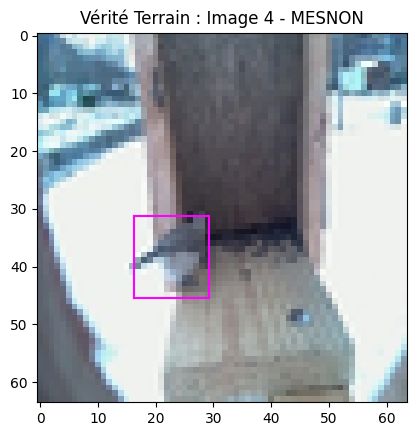

In [19]:
# Instanciation d'une Sequence
train_gen = MangeoireSequence(x_train, y_train, 16, augmentations=AUGMENTATIONS_TRAIN)

# Pour tester la séquence, nous sélectionnons les éléments du premier batch et les affichons
batch_x, batch_y = train_gen.__getitem__(0)

y_batch = np.zeros((batch_y[0].shape[0],1+4+num_classes))

for i in range(batch_y[0].shape[0]):
  y_batch[i, 0] = batch_y[0][i]
  y_batch[i, 1:5] = batch_y[1][i]
  y_batch[i, 5:] = batch_y[2][i]

print_data_localisation(batch_x, y_batch, image_size=IMAGE_SIZE)

**Travail à faire** : lancez un nouvel apprentissage avec l'augmentation de données. Vous remplacerez, dans l'appel à la fonction ```fit```, les variables ```x_train``` et ```y_train``` par l'unique variable ```train_gen```.


Vous devriez observer une nouvelle amélioration des résultats.

### Transfert d'apprentissage

Nous avons vu en première année comment le transfert d'apprentissage pouvait également améliorer les résultats et limiter le sur-apprentissage. L'utilisation d'un réseau pré-entraîné permet souvent de mieux généraliser.

Le bloc suivant permet de charger l'architecture du réseau VGG-16 :

In [20]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(64, 64, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Une fois cette base convolutive chargée, vous pouvez créer un nouveau modèle en y adjoignant les couches de sortie que vous avez déjà créées lors de la séance précédente

```
input_layer = Input(shape=input_shape)
vgg = conv_base(input_layer)
...
```

**Travail à faire**

Testez maintenant l'entraînement de ce réseau, en utilisant également l'augmentation de données. A vous de voir en fonction de vos premiers résultats quelle est la meilleure fonction de coût à utiliser.

Vous devriez obtenir un résultats avoisinant les 80% de bonnes détections.

# Détection d'objet : version simplifiée de YOLO

<center> <img src="https://drive.google.com/uc?id=1V4aAS7K_Akj83apuMZ2vRjNvjgdgoOCh" width=500></center>
<caption><center> Pipeline de l'algorithme YOLO ([Redmon 2016]) </center></caption>

Dans cette partie, nous allons tenter d'aller un peu plus loin en considérant le problème plus complexe de la détection d'objet, c'est-à-dire de la localisation et la classification conjointe de tous les objets dans l'image ; pour cela nous allons implémenter une version simplifiée de YOLO. Cette version est considérée simplifiée car ne reprenant pas l'intégralité des éléments décrite dans l'article de Redmon (par exemple, sur le choix de l'optimiseur). Une des simplifications principales est également que nous ne considérerons **qu'un objet par cellule**.

Pour rappel, l'idée de YOLO est de découper l'image en une grille de cellules et de réaliser une prédiction de plusieurs boîtes englobantes ainsi qu'une classification par cellule. La vidéo de la cellule suivante rappelle les concepts vus en cours sur YOLO et la détection d'objet en général.



Récupération des données

In [21]:
!git clone https://github.com/axelcarlier/wildlife.git

Cloning into 'wildlife'...
remote: Enumerating objects: 2973, done.
remote: Total 2973 (delta 0), reused 0 (delta 0), pack-reused 2973 (from 1)
Receiving objects: 100% (2973/2973), 433.18 MiB | 39.42 MiB/s, done.
Updating files: 100% (3008/3008), done.


## Fonctions utiles

Définition des différentes variables utiles pour la suite

In [22]:
IMAGE_SIZE = 64 # Dimension des images en entrée du réseau
CELL_PER_DIM = 8 # Nombre de cellules en largeur et en hauteur
BOX_PER_CELL = 1 # Nombre d'objets par cellule
NB_CLASSES = 4 # Nombre de classes du problème
PIX_PER_CELL = round(IMAGE_SIZE/CELL_PER_DIM)

CLASS_LABELS = ['buffalo', 'elephant', 'rhino', 'zebra']

### Chargement des données

On charge les images dans la dimension demandée, dans un tenseur $x$. Pour les labels, on ne les structure pas directement dans le format YOLO, mais on les place dans une liste de liste de listes : la longueur de la liste parente est celle du nombre d'images de la base, celle de la liste intermédiaire est celle du nombre d'objets d'une image donnée, et enfin la liste de plus bas niveau a une longueur 5 et contiendra les coordonnées de boîte englobante et les labels de classe associés.

In [23]:
import numpy as np

import math


import PIL
from PIL import Image
import glob, os, sys

for file in glob.glob("*.txt"):
    print(file)

def load_data_detection(ds_path):

  y_paths = []
  # Détermination du nombre d'images total
  for c in CLASS_LABELS:
    path = ds_path + c + '/'
    for file in os.listdir(path):
      if file.endswith('.txt'):
          y_paths.append(os.path.join(path, file))

  dataset_size = len(y_paths)

  # Préparation des structures de données pour x et y
  x = np.zeros((dataset_size, IMAGE_SIZE, IMAGE_SIZE, 3))
  y = []

  for i in range(len(y_paths)):
    text_path = y_paths[i]
    img_path = text_path[:-3] + 'jpg'

    if not os.path.exists(img_path):
      img_path = text_path[:-3] + 'JPG'

    # Lecture de l'image : on va remplir la variable x
    # Lecture de l'image
    img = Image.open(img_path)
    # Mise à l'échelle de l'image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.LANCZOS)
    # Remplissage de la variable x
    x[i] = np.asarray(img, dtype=np.int32)

    # Texte : coordonnées de boîtes englobantes pour remplir y
    boxes = []
    # Texte : coordonnées de boîtes englobantes pour remplir y
    text_file = open(text_path, "r")
    # Récupération des lignes du fichier texte
    rows = text_file.read().split('\n')
    # Parcours de chaque ligne
    for row in rows:
      if row != '':
        # Séparation des différentes informations
        row = list(row.split(' '))
        box = []
        # réorganisation : les 4 coordonnées de boîte englobantes (castées en flottants) d'abord
        for r in row[1:]:
          box.append(float(r))

        box_normal = [box[0]-box[2]/2, box[1]-box[3]/2, box[0]+box[2]/2, box[1]+box[3]/2]

        # Puis le label de classe (casté en entier) à la suite
        box.append(int(row[0]))
        boxes.append(box)

    y.append(boxes)
  return x, y

# Chemin vers la base de données
ds_path = "./wildlife/"
x ,y = load_data_detection(ds_path)


### Affichage des données

Le code ci-dessous vous permettra d'afficher les images ainsi que leurs boîtes englobantes associées. On peut spécifier l'id d'une image en particulier ou, si l'on en spécifie pas, visualiser une image aléatoire.

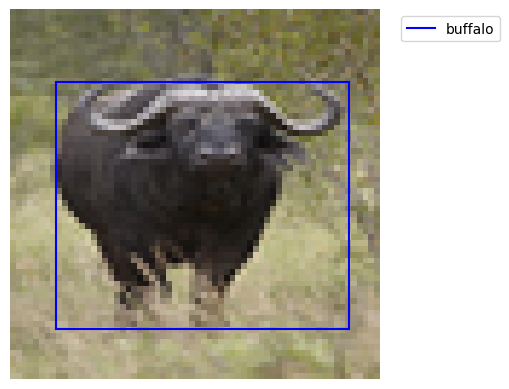

In [25]:
from scipy.special import softmax
import matplotlib.pyplot as plt

def print_data_detection(x, y, id=None, classes=CLASS_LABELS, image_size=IMAGE_SIZE):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0])
  else:
    num_img = id

  img = x[num_img]
  if np.max(img) > 1:
    img = img/255
  boxes = y[num_img]

  colors = ["blue", "yellow", "red", "orange"] # Différentes couleurs pour les différentes classes

  # Affichage de l'image
  plt.imshow(img)
  for box in boxes:

    # Détermination de la classe
    class_id = box[4]

    # Détermination des extrema de la boîte englobante
    p_x = [(box[0]-box[2]/2) * IMAGE_SIZE, (box[0]+box[2]/2) * IMAGE_SIZE]
    p_y = [(box[1]-box[3]/2) * IMAGE_SIZE, (box[1]+box[3]/2) * IMAGE_SIZE]

    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id], label=classes[class_id])
    #plt.title("Vérité Terrain : Image {}".format(num_img, classes[class_id]))

  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.axis('off')
  plt.show()


print_data_detection(x, y, id = 25)


### Écriture des labels au format YOLO

Les deux fonctions ci-dessous sont essentielles car elles permettent de convertir les boîtes englobantes dans le format adopté par YOLO (voir la section Modèle un peu plus bas), mais également de faire l'opération inverse afin d'interpréter la sortie du réseau.

Notez que la fonction *get_box_from_yolo* intègre dans les boîtes englobantes une information supplémentaire par rapport aux données chargées initialement : la probabilité de présence associée à la boîte englobante.

**Travail à faire**
-   Lisez attentivement la fonction ```set_box_for_yolo``` afin de bien comprendre comment les boîtes englobantes sont rangées dans le tenseur YOLO
-   Écrivez la fonction ```get_box_from_yolo``` pour lire les informations dans le tenseur YOLO et créer la liste boîtes englobantes associées.

In [26]:
from tensorflow.keras.utils import to_categorical
from scipy.special import expit, softmax


# Ecrit la liste de boîtes englobantes dans le tenseur YOLO
def set_box_for_yolo(y, num_classes=NB_CLASSES, image_size=IMAGE_SIZE, cell_size=PIX_PER_CELL):
  nb_cells_per_dim = round(image_size/cell_size)

  y_YOLO = np.zeros((len(y), nb_cells_per_dim, nb_cells_per_dim, 1 + 4 + num_classes))

  for i in range(len(y)):
    for box in y[i]:
      # Coordonnées du centre de la boîte englobante dans le repère image
      cx, cy = box[0] * image_size, box[1] * image_size
      # Détermination des indices de la cellule dans laquelle tombe le centre
      ind_x, ind_y = int(cx // cell_size), int(cy // cell_size)
      # YOLO : "The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell."
      # On va donc calculer les coordonnées du centre relativement à la cellule dans laquelle il se situe
      y_YOLO[i, ind_x, ind_y, 1] = (cx - ind_x * cell_size) / cell_size # Coordonnées du centre dans la cellule (normalisées)
      y_YOLO[i, ind_x, ind_y, 2] = (cy - ind_y * cell_size) / cell_size
      # Largeur et hauteur de boîte
      y_YOLO[i, ind_x, ind_y, 3] = box[2]
      y_YOLO[i, ind_x, ind_y, 4] = box[3]

      # Indice de confiance de la boîte englobante pour la cellule correspondante
      y_YOLO[i, ind_x, ind_y, 0] = 1
      # On range les probabilités de classe à la fin du vecteur ([ Présence ; cx ; cy ; w ; h ; CLASSES])
      y_YOLO[i, ind_x, ind_y, 5:] = to_categorical(box[4], num_classes=num_classes)

  return y_YOLO

# Renvoit une liste de boîtes englobantes à partir d'un tenseur YOLO.
# Si mode = 'pred', il s'agit d'une prédiction du réseau, il faut alors utiliser la fonction sigmoide
# pour obtenir la présence prédite, et la fonction softmax pour obtenir les probabilités de classe
# Dans tous les cas, on renvoit uniquement les boîtes englobantes donc l'indice de confiance excède
# le seuil confidence_threshold
def get_box_from_yolo(y_YOLO, mode=None, confidence_threshold=0.5, num_classes=NB_CLASSES, image_size=IMAGE_SIZE, cell_size=PIX_PER_CELL):
  boites = []
  for image in range(y_YOLO.shape[0]):
    boxes = []
    for ind_x in range(y_YOLO.shape[1]):
      for ind_y in range(y_YOLO.shape[2]):
        if mode == 'pred':
          presence = expit(y_YOLO[image, ind_x, ind_y, 0])
          proba_classes = softmax(y_YOLO[image, ind_x, ind_y, 5:])
        else:
          presence = y_YOLO[image, ind_x, ind_y, 0]
          proba_classes = y_YOLO[image, ind_x, ind_y, 5:]

        if presence > confidence_threshold:
          box = []
          box_coord = y_YOLO[image, ind_x, ind_y, 1:5]

          box.append((box_coord[0]*cell_size + ind_x*cell_size)/image_size)
          box.append((box_coord[1]*cell_size + ind_y*cell_size)/image_size)
          box.append(box_coord[2])
          box.append(box_coord[3])
          box.append(np.argmax(proba_classes))
          box.append(presence)

          boxes.append(box)

    boites.append(boxes)
  return boites

# On s'assure de pouvoir passer d'une représentation à l'autre sans altérer les données
print(y[:2])
print(get_box_from_yolo(set_box_for_yolo(y[:2])))

[[[0.470313, 0.547973, 0.8625, 0.733784, 0]], [[0.45671, 0.603333, 0.904762, 0.78, 0]]]
[[[0.470313, 0.547973, 0.8625, 0.733784, 0, 1.0]], [[0.45671, 0.603333, 0.904762, 0.78, 0, 1.0]]]


**Résultat attendu**
```
[[[0.483984, 0.522973, 0.749219, 0.645946, 0]], [[0.509375, 0.649324, 0.80625, 0.595946, 0]]]
[[[0.483984, 0.522973, 0.749219, 0.645946, 0, 1.0]], [[0.509375, 0.649324, 0.80625, 0.595946, 0, 1.0]]]
```

**Fin de la séance 2**


---



### Augmentation de données

Dans la cellule ci-dessous, il vous faudra intégrer les augmentations que vous aurez choisi. **Attention, ne faites cette partie que dans un second temps, lorsque vous aurez une première version du réseau qui fonctionnera !**

Aidez-vous de [cette page](https://albumentations.ai/docs/getting_started/transforms_and_targets/) pour déterminer des augmentations qui peuvent fonctionner.

In [ ]:
from albumentations import (Compose, ShiftScaleRotate, HorizontalFlip)
import albumentations as A

AUGMENTATIONS_TRAIN = Compose([
    #### A COMPLETER, MAIS SEULEMENT LORSQUE VOUS AVEZ UN RESEAU QUI (SUR-)APPREND !
    # HorizontalFlip(p=0.5),
    # ...
], bbox_params=A.BboxParams(format='yolo'))

L'objet ```Sequence``` défini ci-dessous nous permettra la mise en batch de nos données. Il est très similaire à celui de la localisation d'objet mais il utilise les fonctions ```set_box_for_yolo``` et ```get_box_from_yolo```

In [ ]:
from tensorflow.keras.utils import Sequence

class YOLOSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0], dtype='int')
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))


    # Il y a des problèmes d'arrondi dans les conversions de boîtes englobantes
    # internes à la librairie Albumentations
    # Pour les contourner, si les boîtes sont trop proches des bords, on les érode un peu
    def erode_bounding_box(self, box, epsilon = 0.02):
        eroded_box = []

        xmin = max(box[0] - box[2]/2, epsilon)
        ymin = max(box[1] - box[3]/2, epsilon)
        xmax = min(box[0] + box[2]/2, 1-epsilon)
        ymax = min(box[1] + box[3]/2, 1-epsilon)

        cx = xmin + (xmax - xmin)/2
        cy = ymin + (ymax - ymin)/2
        width = xmax - xmin
        height = ymax - ymin

        eroded_box = [cx, cy, width, height, box[4]]
        return eroded_box

    # Application de l'augmentation de données à chaque image du batch et aux
    # boîtes englobantes associées
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros((bx.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        batch_y = []

        # Pour chaque image du batch
        for i in range(len(bx)):
            boxes = []
            # Erosion des boîtes englobantes
            for box in by[i]:
              boxes.append(self.erode_bounding_box(box))

            # Application de l'augmentation à l'image et aux boîtes englobantes
            transformed = self.augment(image=bx[i].astype('float32'), bboxes=boxes)
            batch_x[i] = transformed['image']
            batch_y_transformed = transformed['bboxes']
            batch_y.append(batch_y_transformed)

        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        # Sélection des indices des données du prochain batch
        batch_indices = self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]
        # Récupération des données puis des labels du batch
        batch_x = self.x[batch_indices]
        batch_boxes = [self.y[item] for item in list(batch_indices)]
        # Application de l'augmentation de données
        batch_x_aug, batch_boxes_aug = self.apply_augmentation(batch_x, batch_boxes)

        # Préparation des données pour le réseau :
        # Normalisation des entrées
        batch_x_aug = batch_x_aug/255
        # Passage des sorties au format YOLO
        batch_y_YOLO = set_box_for_yolo(batch_boxes_aug)

        return np.array(batch_x_aug), batch_y_YOLO

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)



In [ ]:
# Instanciation d'une Sequence
train_gen = YOLOSequence(x[:1], y[:1], 1, augmentations=AUGMENTATIONS_TRAIN)

# Pour tester la séquence, nous sélectionnons les éléments du premier batch et les affichons
batch_x, batch_y = train_gen.__getitem__(0)

print_data_detection(batch_x, get_box_from_yolo(batch_y))

## Implémentation de YOLO

### Modèle

<center> <img src="https://drive.google.com/uc?id=1_wXc_gTIAr37STaxu3chq1EEjVSKv6a5" width=500></center>
<caption><center> Illustration de la couche de sortie de YOLO. </center></caption>

Le modèle que je vous propose ci-dessous n'est qu'une possibilité parmi beaucoup d'autres.
A vous de compléter la dernière couche pour avoir une sortie de la bonne dimension.

**Remarque importante** : comme le tenseur de sortie de YOLO est un peu complexe à manipuler, on choisit ici de regrouper l'ensemble des prédictions dans une seule et même sortie, ce qui nous oblige à utiliser la même fonction d'activation pour toutes nos sorties. On utilisera donc l'activation **linéaire** pour toutes ces sorties. On appliquera les fonctions sigmoïde et softmax pour les sorties "présence" et "probablités de classe" directement dans la fonction de coût !

In [27]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers


def create_model_YOLO(input_shape=(64, 64, 3)):
  input_layer = Input(shape=input_shape)

  conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(1024, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  ### A COMPLETER
  output = Dense(1 + 4 + num_classes, activation='linear', name='output')(conv4)

  model = Model(input_layer, output)

  return model

In [28]:
model = create_model_YOLO()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 1024)          │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 8, 8, 16)            │          16,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,484,080 (5.66 MB)

 Trainable params: 1,484,080 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

### Fonction de coût

<center> <img src="https://drive.google.com/uc?id=1Fbt_Wh_BqZj8Pwt3-04325ItCkQp5G9X" style="width:500;height:300px;"></center>
<caption><center> Détail de la fonction de perte définie dans l'article YOLO v1 </center></caption>

Nous arrivons maintenant à la partie délicate de l'implémentation de YOLO : la définition de la fonction de coût à utiliser. En effet cette fonction de coût, qui sera appelée pendant l'entraînement, traitera des tenseurs et non des tableau *numpy*. On doit donc utiliser la librairie Tensorflow qui permet de manipuler les tenseurs. Les fonctions dont vous aurez besoin sont décrites majoritairement sur [cette page](https://www.tensorflow.org/api_docs/python/tf/math), ainsi qu'[ici](https://www.tensorflow.org/api_docs/python/tf/nn).

Une partie essentielle de la fonction est déjà écrite (fonction YOLO_loss) : celle qui permet de séparer les données des cellules dites "vide" (la vérité terrain ne contient pas de boîte englobante) des "non vides". Cette fonction est apelée en première, et fait appel aux 3 sous-fonctions box_loss, coord_loss, et nobox_loss que vous devez compléter.

Le détail de la fonction de coût est indiqué ci-dessus : dans l'article $\lambda_{\text{coord}} = 5$ et $\lambda_{\text{noobj}} = 0.5$. Les $x_i$, $y_i$, $w_i$, $h_i$ correspondent aux coordonnées d'une boîte englobante, $C_i$ correspond à la probabilité de présence d'un objet dans la cellule, et les $p_i(c)$ sont les probabilités de classe.

A vous de compléter l'expression des sous-fonctions de la fonction de coût. **N'oubliez pas d'appliquer une sigmoïde aux présences ($C_i$) et une softmax aux probabilités de classe $p_i$) !!**

**NB : cette implémentation de la fonction de coût est très simplifiée et prend en compte le fait qu'il n'y a qu'une seule boîte englobante par cellule.**

**NB 2: la fonction tf.math.sqrt peut retourner NaN si elle est appelée sur une entrée négative. Un fix qui fonctionne est d'écrire tf.math.sqrt(tf.maximum(x, 1e-9)) pour qu'elle retourne une valeur proche de 0 plutôt que NaN.**


In [29]:
from keras import backend as K
import tensorflow as tf

### A COMPLETER
# Définition de la fonction de perte YOLO
def YOLOss(lambda_coord, lambda_noobj, batch_size):

    # Partie "verte" : sous-partie concernant l'indice de confiance et les
    # probabilités de classe dans le cas où une boîte est présente dans la cellule
    def box_loss(y_true, y_pred):
      return tf.math.square(tf.math.substract(y_true[:,1:5],y_pred[:,1:5]))

    # Partie "bleue" : sous-partie concernant les coordonnées de boîte englobante
    # dans le cas où une boîte est présente dans la cellule
    def coord_loss(y_true, y_pred):
      return ...


    # Partie "rouge" : sous-partie concernant l'indice de confiance
    # dans le cas où aucune boîte n'est présente dans la cellule
    def nobox_loss(y_true, y_pred):
      return ...


    def YOLO_loss(y_true, y_pred):

      # On commence par reshape les tenseurs de bs x S x S x (5B+C) à (bsxSxS) x (5B+C)
      y_true = tf.reshape(y_true, [-1, 9])
      y_pred = tf.reshape(y_pred, [-1, 9])

      # On cherche (dans les labels y_true) les indices des cellules pour lesquelles au moins la première boîte englobante est présente
      not_empty = tf.math.greater_equal(y_true[:, 0], tf.constant([1.0]))
      indices = tf.range(tf.shape(y_true)[0])
      indices_notempty_cells = indices[not_empty]

      empty = tf.math.less_equal(y_true[:, 0], tf.constant([0.0]))
      indices_empty_cells = indices[empty]

      # On sépare les cellules de y_true et y_pred avec ou sans boîte englobante
      y_true_notempty = tf.gather(y_true, indices_notempty_cells)
      y_pred_notempty = tf.gather(y_pred, indices_notempty_cells)

      y_true_empty = tf.gather(y_true, indices_empty_cells)
      y_pred_empty = tf.gather(y_pred, indices_empty_cells)


      return (box_loss(y_true_notempty, y_pred_notempty) + lambda_coord*coord_loss(y_true_notempty, y_pred_notempty) + lambda_noobj*nobox_loss(y_true_empty, y_pred_empty))/batch_size


    # Return a function
    return YOLO_loss

### Apprentissage

Comme d'habitude, on sépare nos données en plusieurs ensembles (ici apprentissage et validation suffiront).

In [ ]:
# Séparation des données en ensemble de validation et d'apprentissage
indices = np.arange(x.shape[0], dtype='int')
np.random.seed(1)
np.random.shuffle(indices)

x_train = x[indices[:1355]]
y_train = [y[i] for i in indices[:1355]]

x_val = x[indices[1355:]]
y_val = [y[i] for i in indices[1355:]]

y_val_YOLO = set_box_for_yolo(y_val)


Prenez le temps de tester votre modèle et votre fonction de coût, ainsi que vos réglages d'hyperparamètres, en sur-apprenant sur une image d'abord, puis sur un batch d'images. Entraînez votre réseau et visualisez ses prédictions sur les données d'entraînement, puis de validation, pour obtenir une intuition sur les valeurs de *loss* permettant d'obtenir des résultats "acceptables".

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

batch_size=16
model = create_model_YOLO()
opt = Adam(learning_rate=3e-4) # NB : n'hésitez pas à tester d'autres valeurs de learning rate

train_gen = YOLOSequence(x_train, y_train, batch_size, augmentations=AUGMENTATIONS_TRAIN)

# Comme l'entraînement est instable, on déclenche une sauvegarde du modèle à chaque fois que
# la perte de validation atteint un nouveau minimum
model_saver = ModelCheckpoint('tmp/best_weights', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

loss=[YOLOss(5, 0.5, batch_size)]

model.compile(loss=loss,
              optimizer=opt)

history = model.fit(train_gen,
              epochs=150,
              batch_size=batch_size,
              validation_data=(x_val/255, y_val_YOLO),
              callbacks = [model_saver])


### Test et affichage des résultats

#### Test de la version à l'issue de l'entraînement

**Sur l'ensemble d'apprentissage**

In [ ]:
y_pred = model.predict(x_train/255)
y_pred_YOLO = get_box_from_yolo(y_pred, confidence_threshold=0.3, mode='pred')
print_data_detection(x_train, y_pred_YOLO)

In [ ]:
print_data_detection(x_train, y_pred_YOLO)

**Sur l'ensemble de validation**

In [ ]:
y_pred = model.predict(x_val/255)
y_pred_YOLO = get_box_from_yolo(y_pred, confidence_threshold=0.5, mode='pred')
print_data_detection(x_val, y_pred_YOLO)

In [ ]:
print_data_detection(x_val, y_pred_YOLO)

#### Test de la meilleure version sauvegardée

La cellule ci-dessous vous permettra de charger les poids sauvegardés lorsque la meilleur performance a été atteinte sur l'ensemble de validation pendant l'entraînement.

In [ ]:
model.load_weights('tmp/best_weights')

**Sur l'ensemble d'apprentissage**

In [ ]:
y_pred = model.predict(x_train/255)
y_pred_YOLO = get_box_from_yolo(y_pred, confidence_threshold=0.3, mode='pred')
print_data_detection(x_train, y_pred_YOLO)

In [ ]:
print_data_detection(x_train, y_pred_YOLO)

**Sur l'ensemble de validation**

In [ ]:
y_pred = model.predict(x_val/255)
y_pred_YOLO = get_box_from_yolo(y_pred, confidence_threshold=0.3, mode='pred')
print_data_detection(x_val, y_pred_YOLO)

In [ ]:
print_data_detection(x_val, y_pred_YOLO)